In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
import math
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def pick_house(data,i):
    #i is number of house in the list you want
    house_list = data['LCLid'].unique().tolist()
    df = data[data['LCLid']==house_list[i]][:-2]
    df = df.drop_duplicates()
    return df

In [4]:
# load the consumption dataset of all the houses
energy = pd.read_csv('energy.csv', header=0, infer_datetime_format=True,
                parse_dates=['day'], index_col=['day'])
df = pick_house(energy,2793)
df = df.drop(['Unnamed: 0','LCLid'], axis=1)

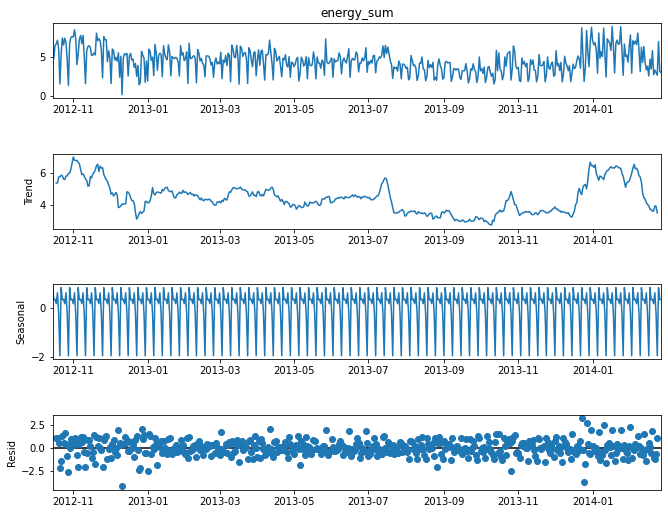

In [5]:
result = seasonal_decompose(df['energy_sum'], model='additive',freq=7)
fig = result.plot()
fig.set_figheight(8)
fig.set_figwidth(10)
plt.show()

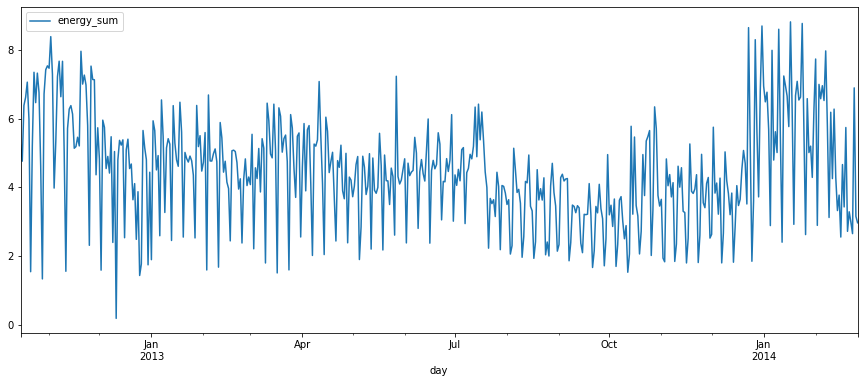

In [6]:
df.plot(figsize=(15,6))
plt.show()

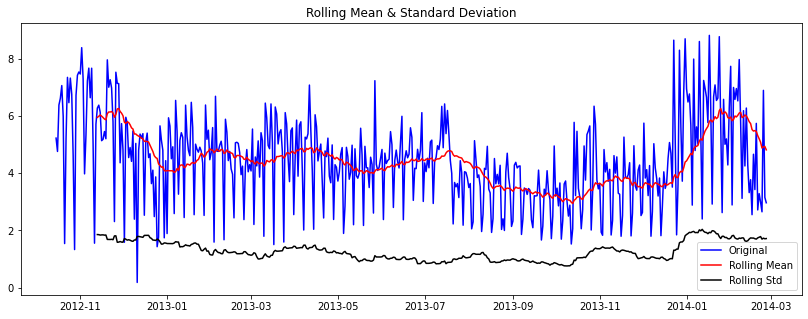

<Results of Dickey-Fuller Test>
Test Statistic                  -2.496795
p-value                          0.116256
#Lags Used                      14.000000
Number of Observations Used    485.000000
Critical Value (1%)             -3.443905
Critical Value (5%)             -2.867518
Critical Value (10%)            -2.569954
dtype: float64


In [7]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df['energy_sum'])

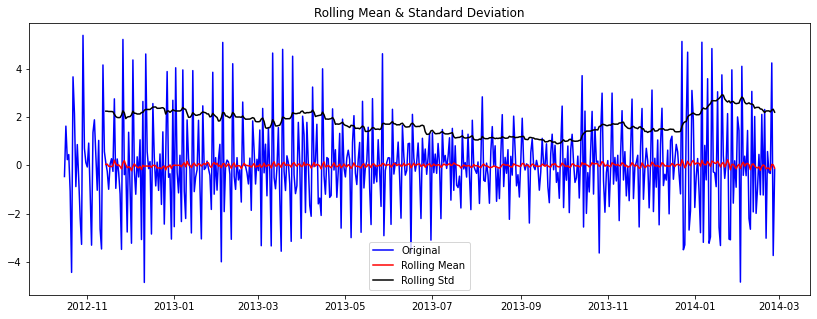

<Results of Dickey-Fuller Test>
Test Statistic                -8.541555e+00
p-value                        9.751932e-14
#Lags Used                     1.300000e+01
Number of Observations Used    4.850000e+02
Critical Value (1%)           -3.443905e+00
Critical Value (5%)           -2.867518e+00
Critical Value (10%)          -2.569954e+00
dtype: float64


In [8]:
different = df['energy_sum'].diff().dropna()
test_stationarity(different)

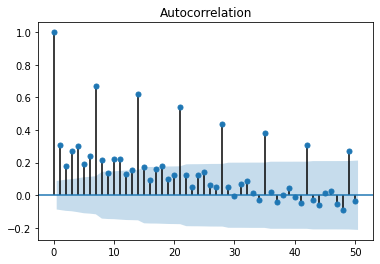

In [9]:
plot_acf(df,lags = 50)
plt.show()

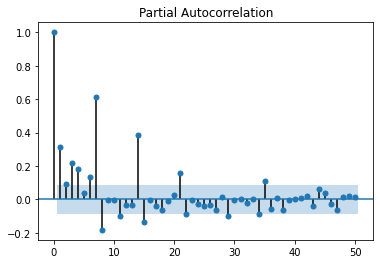

In [10]:
plot_pacf(df,lags = 50)
plt.show()

In [11]:
train, test = train_test_split(df['energy_sum'], train_size = 0.8, test_size = 0.2, shuffle = False)
train.tail(3)

day
2013-11-16    1.794
2013-11-17    2.513
2013-11-18    5.259
Name: energy_sum, dtype: float64

In [12]:
test.head(3)

day
2013-11-19    3.879
2013-11-20    3.818
2013-11-21    3.948
Name: energy_sum, dtype: float64

In [13]:
import statsmodels.api as sm

arima = sm.tsa.statespace.SARIMAX(train,
                                    order=(7,1,7),
                                    seasonal_order=(0,0,0,0),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

results = arima.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             energy_sum   No. Observations:                  400
Model:               SARIMAX(7, 1, 7)   Log Likelihood                -501.776
Date:                Thu, 10 Sep 2020   AIC                           1033.552
Time:                        11:54:09   BIC                           1093.083
Sample:                    10-15-2012   HQIC                          1057.148
                         - 11-18-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9365      0.084    -11.206      0.000      -1.100      -0.773
ar.L2         -0.9240      0.086    -10.684      0.000      -1.094      -0.755
ar.L3         -0.9150      0.086    -10.673      0.0

In [14]:
pred = results.get_prediction(start='2013-11-19 ',end = '2013-12-05 ', dynamic=False)
pred_ci = pred.conf_int(alpha = 0.1)

In [15]:
print('ARIMA model mean absolute error:{}'.format(mean_absolute_percentage_error(test[:17],pred.predicted_mean)))

ARIMA model mean absolute error:9.674779183038432


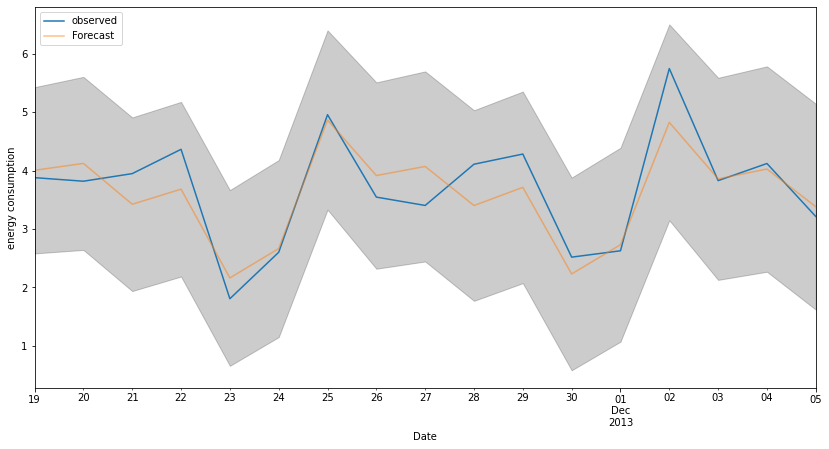

In [16]:
ax = test[:17].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.5, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('energy consumption')
plt.legend(loc='upper left')
plt.show()

In [47]:
# sarima = sm.tsa.statespace.SARIMAX(train,
#                                     order=(7,1,7),
#                                     seasonal_order=(7,1,7,1),
#                                     enforce_stationarity=False,
#                                     enforce_invertibility=False, freq = 'D').fit()
# print(sarima.summary())

In [48]:
pred_sarima = sarima.get_prediction(start='2013-11-19 ',end = '2013-12-05 ', dynamic=False)
pred_ci_sarima = pred_sarima.conf_int(alpha = 0.1)

In [49]:
print('ARIMA model mean absolute error:{}'.format(mean_absolute_percentage_error(test[:17],pred_sarima.predicted_mean)))

ARIMA model mean absolute error:9.674779183038432


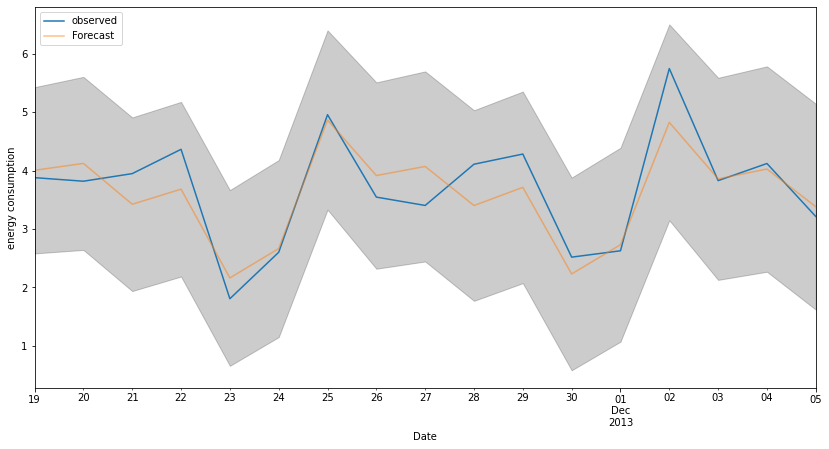

In [50]:
ax = test[:17].plot(label='observed')
pred_sarima.predicted_mean.plot(ax=ax, label='Forecast', alpha=.5, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('energy consumption')
plt.legend(loc='upper left')
plt.show()

In [51]:
# load holiday dataset 
holiday = pd.read_csv('uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday.set_index('Bank holidays', inplace=True)

In [52]:
# merge holiday dataset with energy consumption and weather dataset
full_df=pd.merge(df,holiday, how='outer', left_index=True, right_index=True)
# create a feature that indicates whether the day is holiday or not (0: for normalday, 1: for holiday)
full_df['holiday_ind'] = np.where(full_df['Type'].isna(),0,1)

In [53]:
full_df.drop(['Type'], axis=1, inplace=True)


In [54]:
full_df.dropna(axis=0, inplace=True)

In [55]:
# Create new features from date time index of the dataset
full_df['date'] = full_df.index
full_df['dayofweek'] = full_df['date'].dt.dayofweek
full_df['quarter'] = full_df['date'].dt.quarter
full_df['month'] = full_df['date'].dt.month
full_df['year'] = full_df['date'].dt.year
full_df['dayofyear'] = full_df['date'].dt.dayofyear
full_df['dayofmonth'] = full_df['date'].dt.day
full_df['weekofyear'] = full_df['date'].dt.weekofyear
full_df.drop(['date'], axis = 1, inplace = True)

In [56]:
train_ex, test_ex = train_test_split(full_df, train_size = 0.8, test_size = 0.2, shuffle = False)

In [57]:
ex_train_feature = train_ex[['holiday_ind','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
ex_test_feature = test_ex[['holiday_ind','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]

In [58]:
arimax = sm.tsa.statespace.SARIMAX(train,order=(7,1,7),seasonal_order=(0,0,0,0),exog = ex_train_feature,freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             energy_sum   No. Observations:                  400
Model:               SARIMAX(7, 1, 7)   Log Likelihood                -493.911
Date:                Thu, 10 Sep 2020   AIC                           1033.822
Time:                        14:45:51   BIC                           1125.102
Sample:                    10-15-2012   HQIC                          1070.002
                         - 11-18-2013                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
holiday_ind    -1.0163      0.166     -6.140      0.000      -1.341      -0.692
dayofweek      -0.4254      0.184     -2.314      0.021      -0.786      -0.065
quarter        -0.3568      0.402     -0.887      0.375      -1.145       0.431
month          -6.1708      4.839     -1.275      0.202     -15.654       3.313
year           -0.3467      2.866     -0.121      0.904      -5.965       5.271
dayofyear       0.2024      0.160      1.263      0.207      -0.112       0.517
dayofmonth     -0.1998      0.159     -1.253      0.210      -0.512       0.113
weekofyear  -9.732e-05      0.049     -0.002      0.998      -0.097       0.097
ar.L1          -0.9103      0.097     -9.383      0.000      -1.100      -0.720
ar.L2          -0.8804      0.092     -9.567      0.000      -1.061      -0.700
ar.L3          -0.8873      0.084    -10.614      0.000      -1.051      -0.723
ar.L4          -0.8742      0.086    -10.117      0.000      -1.044      -0.705
ar.L5          -0.8666      0.084    -10.367      0.000      -1.030      -0.703
ar.L6          -0.8808      0.079    -11.165      0.000      -1.035      -0.726
ar.L7           0.0741      0.081      0.919      0.358      -0.084       0.232
ma.L1           0.1569      0.085      1.852      0.064      -0.009       0.323
ma.L2           0.0449      0.048      0.942      0.346      -0.048       0.138
ma.L3           0.1039      0.059      1.768      0.077      -0.011       0.219
ma.L4           0.0921      0.053      1.740      0.082      -0.012       0.196
ma.L5           0.1165      0.057      2.058      0.040       0.006       0.227
ma.L6           0.1480      0.049      3.030      0.002       0.052       0.244
ma.L7          -0.6631      0.051    -12.994      0.000      -0.763      -0.563
sigma2          0.7125      0.041     17.380      0.000       0.632       0.793
===================================================================================
Ljung-Box (Q):                       34.79   Jarque-Bera (JB):               397.82
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA model mean absolute error:12.109967937346745


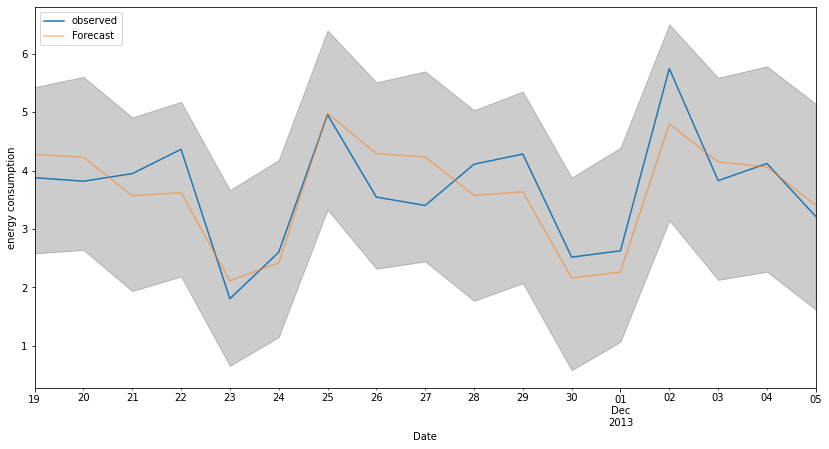

In [59]:
pred_arimax = arimax.get_prediction(start='2013-11-19 ',end = '2013-12-05 ', exog = ex_test_feature[:17],dynamic=False)
pred_ci_armiax = pred_sarima.conf_int(alpha = 0.1)
print('ARIMA model mean absolute error:{}'.format(mean_absolute_percentage_error(test[:17],pred_arimax.predicted_mean)))
ax = test[:17].plot(label='observed')
pred_arimax.predicted_mean.plot(ax=ax, label='Forecast', alpha=.5, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1],color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('energy consumption')
plt.legend(loc='upper left')
plt.show()